In [1]:
!pip install pytorch-lightning

In [2]:
# 3rd party
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.signal import hilbert
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_networkx

In [3]:
# local
from models import GATv2Lightning

CUDA setup

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Import data

1 - epilepsy
0 - control

In [5]:
eeg_points: list[str] = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
label_encoder: dict[str, int] = {
    'epilepsy' : 1, 
    "control" : 0
}

studies: list[pd.Series] = []

In [6]:
# Guinea Bissau
meta_gb = pd.read_csv("DATASET/metadata_guineabissau.csv")

In [7]:
def get_closed_eyes_signal(signal: pd.DataFrame) -> pd.DataFrame:
    num_rows: int = len(signal)
    return signal[int(3 * num_rows / 5):]

In [8]:
for row in meta_gb.iterrows():
    subject_id = row[1]['subject.id']
    label = label_encoder[row[1].Group.lower()]
    signal = pd.read_csv(f"DATASET/EEGs_Guinea-Bissau/signal-{subject_id}.csv")
    signal = signal[eeg_points]
    
    closed_eyes_signal = get_closed_eyes_signal(signal)

    studies.append(closed_eyes_signal)

In [9]:
# Nigeria
meta_nig = pd.read_csv("DATASET/metadata_nigeria.csv")

In [10]:
for _, row in meta_nig.iterrows():
    subject_id = row['subject.id']
    label = label_encoder[row.Group]
    filename = row['csv.file'][:-3]
    signal = pd.read_csv(f"DATASET/EEGs_Nigeria/{filename}")
    signal = signal[eeg_points]
    
    closed_eyes_signal = get_closed_eyes_signal(signal)

    studies.append(closed_eyes_signal)

In [11]:
len(studies)

318

In [12]:
print(type(studies[0]))

<class 'pandas.core.frame.DataFrame'>


In [13]:
studies[0]

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8
23116,4064.615385,3748.717949,4046.666667,3572.307692,3704.102564,3573.333333,4488.717949,3920.000000,4103.589744,4070.256410,3877.435897,3985.128205,3700.000000,3803.076923
23117,4057.948718,3738.461538,4038.974359,3564.102564,3708.717949,3560.000000,4483.589744,3908.205128,4103.076923,4061.025641,3870.256410,3976.923077,3695.384615,3792.307692
23118,4050.769231,3729.230769,4032.820513,3554.871795,3706.666667,3554.871795,4475.384615,3905.128205,4102.564103,4061.025641,3862.051282,3971.794872,3689.230769,3787.179487
23119,4048.205128,3730.256410,4032.820513,3555.897436,3706.153846,3565.128205,4476.923077,3909.743590,4104.102564,4069.230769,3868.205128,3979.487179,3689.743590,3793.846154
23120,4054.358974,3742.051282,4042.564103,3568.205128,3716.923077,3575.384615,4487.692308,3920.000000,4111.794872,4076.410256,3878.974359,3989.230769,3696.923077,3803.589744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38523,4049.230769,3826.666667,4003.589744,3550.256410,4229.230769,3572.307692,4376.923077,3721.025641,4197.435897,4053.846154,3893.846154,3973.846154,3681.025641,3817.948718
38524,4056.410256,3832.307692,4002.051282,3554.358974,4230.769231,3575.897436,4375.897436,3724.102564,4198.974359,4051.282051,3894.871795,3972.820513,3685.128205,3818.461538
38525,4060.512821,3835.897436,4006.666667,3561.538462,4233.846154,3574.871795,4367.692308,3726.153846,4199.487179,4052.820513,3894.358974,3970.769231,3685.128205,3813.846154
38526,4052.820513,3827.179487,4006.666667,3559.487179,4229.230769,3571.282051,4372.307692,3723.589744,4198.461538,4054.358974,3891.282051,3970.256410,3681.025641,3814.358974


In [14]:
def compute_plv(matrix, columns):
    n_channels = matrix.shape[1]
    plv_matrix = np.zeros((n_channels, n_channels))

    phases = np.angle(hilbert(matrix, axis=0))

    for i in range(n_channels):
        for j in range(n_channels):
            phase_diff = phases[:, i] - phases[:, j]
            plv_matrix[i, j] = np.abs(np.mean(np.exp(1j * phase_diff)))

    return pd.DataFrame(plv_matrix, columns=columns, index=columns)

for i, study in enumerate(studies):
    studies[i] = compute_plv(study.values, study.columns)  


In [15]:
for i, study in enumerate(studies):
    studies[i] = compute_plv(study.values, study.columns)

In [16]:
assert len(studies) == 318

In [17]:
# for i, study in enumerate(studies):
#     study.to_csv(f"study_{i}.csv", index=False)

In [18]:
from sklearn.model_selection import train_test_split

train_studies, temp_studies = train_test_split(studies, test_size=0.2, random_state=42)
valid_studies, test_studies = train_test_split(temp_studies, test_size=0.5, random_state=42)

print(f"Train size: {len(train_studies)}")
print(f"Validation size: {len(valid_studies)}")
print(f"Test size: {len(test_studies)}")


Train size: 254
Validation size: 32
Test size: 32


In [19]:
def cast_study_to_graph(study):
    x = torch.tensor(study.values, dtype=torch.float)  
    num_nodes = x.size(0)
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()  
    edge_attr = torch.ones(edge_index.size(1), dtype=torch.float) 
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

In [20]:
def add_masks(data, train_ratio=0.6, val_ratio=0.2):
    num_nodes = data.x.size(0)
    indices = torch.randperm(num_nodes)

    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)

    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[indices[:train_size]] = 1
    data.val_mask[indices[train_size:train_size + val_size]] = 1
    data.test_mask[indices[train_size + val_size:]] = 1

    return data

In [21]:
def add_target_labels(data, num_classes=2):
    num_nodes = data.x.size(0)
    data.y = torch.randint(0, num_classes, (num_nodes,))
    return data

In [22]:
graph_data_list = [cast_study_to_graph(study) for study in studies]
graph_data_list = [add_masks(data) for data in graph_data_list]
graph_data_list = [add_target_labels(data) for data in graph_data_list]

In [23]:
graph_data_list

[Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 Data(x=[14, 14], edge_index=[2, 91], edge_attr=[91], train_mask=[14], val_mask=[14], test_mask=[14], y=[14]),
 

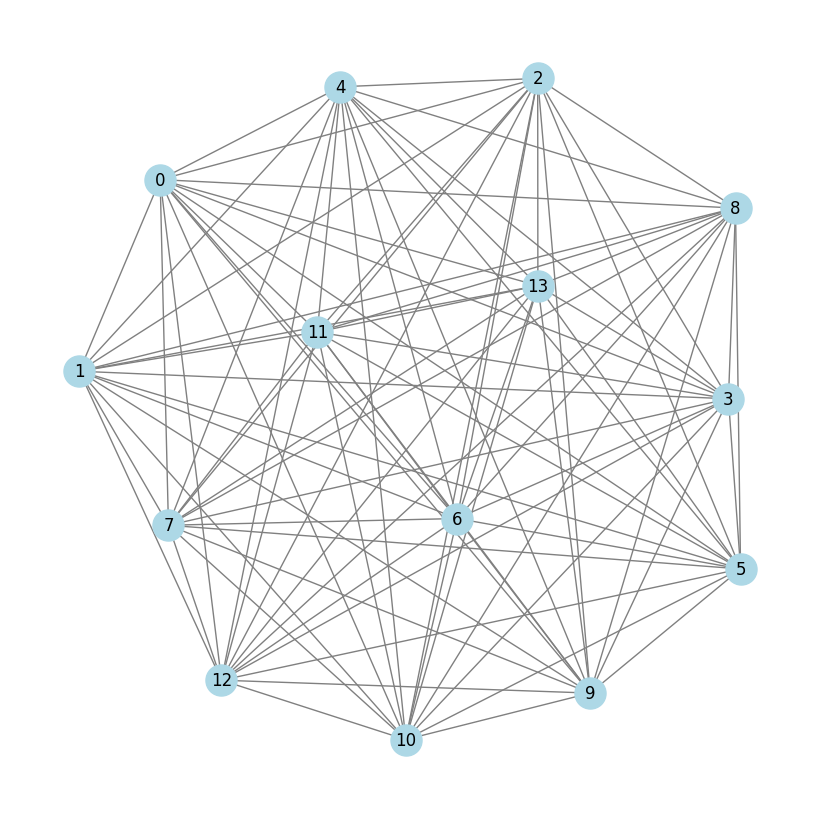

In [24]:
train_sample = graph_data_list[0]
G = to_networkx(train_sample, to_undirected=True)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.show()

In [25]:
loader = DataLoader(graph_data_list, batch_size=32, shuffle=True)

e:\Users\PanSt\OneDrive\Pulpit\Python\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
in_features = 14  # Number of input features per node
n_gat_layers = 2  # Number of GAT layers
hidden_dim = 16  # Number of hidden units per attention head
n_heads = 4  # Number of attention heads
dropout = 0.5  # Dropout rate
slope = 0.2  # LeakyReLU slope
pooling_method = 'mean'  # Pooling method 
activation = 'relu'  # Activation function
norm_method = None  # Normalization method 
n_classes = 2  # Number of output classes
lr = 0.01  # Learning rate
weight_decay = 5e-4  # Weight decay

In [27]:
model = GATv2Lightning(in_features, n_gat_layers, hidden_dim, n_heads, dropout, slope,
                       pooling_method, activation, norm_method, n_classes, lr, weight_decay)

In [28]:
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
criterion = nn.CrossEntropyLoss()

e:\Users\PanSt\OneDrive\Pulpit\Python\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [29]:
def train():
    model.train()
    total_loss = 0
    for data in loader:
        print(f'Training data.x shape: {data.x.shape}')
        print(f'Training data.edge_index shape: {data.edge_index.shape}')
        print(f'Training data.y shape: {data.y.shape}')
        print(f'Training data.train_mask shape: {data.train_mask.shape}')
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        print(f'Training output shape: {out.shape}')
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [30]:
def validate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            print(f'Validation data.x shape: {data.x.shape}')
            print(f'Validation data.edge_index shape: {data.edge_index.shape}')
            print(f'Validation data.y shape: {data.y.shape}')
            print(f'Validation data.val_mask shape: {data.val_mask.shape}')
            out = model(data.x, data.edge_index)
            print(f'Validation output shape: {out.shape}')
            loss = criterion(out[data.val_mask], data.y[data.val_mask])
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [31]:
EPOCHS = 200

In [32]:
for epoch in range(200):
    train_loss = train()
    val_loss = validate()
    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Training data.x shape: torch.Size([448, 14])
Training data.edge_index shape: torch.Size([2, 2912])
Training data.y shape: torch.Size([448])
Training data.train_mask shape: torch.Size([448])
Input x shape: torch.Size([448, 14])
Input edge_index shape: torch.Size([2, 2912])
After GAT layer 1, x shape: torch.Size([448, 64])
After ReLU and Dropout, x shape: torch.Size([448, 64])
After GAT layer 2, x shape: torch.Size([448, 64])
After ReLU and Dropout, x shape: torch.Size([448, 64])
After fc_out, x shape: torch.Size([448, 2])
Training output shape: torch.Size([448, 2])
Training data.x shape: torch.Size([448, 14])
Training data.edge_index shape: torch.Size([2, 2912])
Training data.y shape: torch.Size([448])
Training data.train_mask shape: torch.Size([448])
Input x shape: torch.Size([448, 14])
Input edge_index shape: torch.Size([2, 2912])
After GAT layer 1, x shape: torch.Size([448, 64])
After ReLU and Dropout, x shape: torch.Size([448, 64])
After GAT layer 2, x shape: torch.Size([448, 64])
A